The subjects on the Experiment II are: ['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8']
[0 2 1 1 0]
Accuracy: 0.6


C:\Users\vineeth chaitanya\AppData\Local\Temp\ipykernel_16476\2934400898.py:148: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', len(unique_labels))
C:\Users\vineeth chaitanya\AppData\Local\Temp\ipykernel_16476\2934400898.py:152: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(X_lda[labels == label, 0], X_lda[labels == label, 1], c=cmap(label))


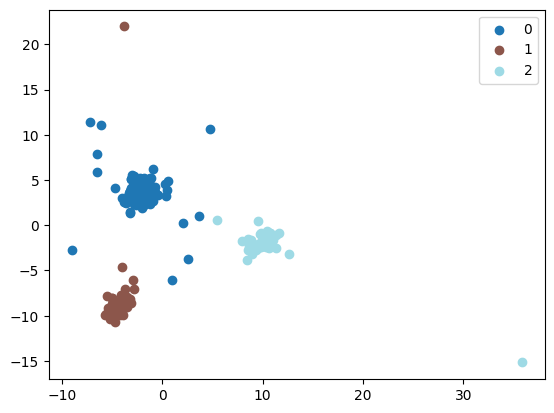

Left


In [ ]:
# Data Load
import os
# import numpy as np 

# PyTorch (modeling)
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms
import torchvision.transforms.functional as TF

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Setting a seed to ensure reproductibility
torch.manual_seed(123)

exp_ii_path = 'C:\\Users\\vineeth chaitanya\\OneDrive\\Desktop\\Project698\\a-pressure-map-dataset-for-in-bed-posture-classification-1.0.0\\experiment-ii'
# Read subjects
subjects_ii = [file for file in os.listdir(exp_ii_path) if os.path.isdir(os.path.join(exp_ii_path, file))]
print(f"The subjects on the Experiment II are: {subjects_ii}")

test_read = np.loadtxt("C:\\Users\\vineeth chaitanya\\OneDrive\\Desktop\\Project698\\a-pressure-map-dataset-for-in-bed-posture-classification-1.0.0\\experiment-ii/S2/Air_Mat/Matrix_Air_B1.txt")
test_read.shape

def resize_and_rotate(image):
  To_PIL_and_Resize = transforms.Compose([
                      transforms.ToPILImage(),
                      transforms.Resize((64, 32))
                      ])

  rotated = TF.rotate(To_PIL_and_Resize(image), angle=180)

  return transforms.ToTensor()(rotated)

# Positions G1, G2, and G3 appear only on Subject 3's air mat measurements. We
# inspected them manually to know the position of it and set the corresponding
# label.

def token_position(x):
    return {
        'supine': 0,
        'left': 1,
        'right': 2,
        'left_fetus': 1,
        'right_fetus': 2
    }[x]

positions_ii = {
    "B":"supine", "1":"supine", "C":"right",
    "D":"left", "E1":"right", "E2":"right",
    "E3":"left", "E4":"left", "E5":"right",
    "E6":"left", "F":"supine", "G1":"supine",
    "G2":"right", "G3":"left"
}

exp_ii_data_air = {}
exp_ii_data_spo = {}

# each directory is a subject
for _, subject_dirs, _ in os.walk(exp_ii_path):
  for subject in subject_dirs:
    data = None
    labels = None

    # each directory is a matress
    for _, mat_dirs, _ in os.walk(os.path.join(exp_ii_path, subject)):
      for mat in mat_dirs:
        for _, _, files in os.walk(os.path.join(exp_ii_path, subject, mat)):
          for file in files:
            file_path = os.path.join(exp_ii_path, subject, mat, file)
            raw_data = np.loadtxt(file_path)
            # Change the range from [0-500] to [0-255].
            file_data = np.round(raw_data*255/500).astype(np.uint8)
            file_data = resize_and_rotate(file_data)
            file_data = file_data.view(1, 64, 32)

            if file[-6] == "E" or file[-6] == "G":
              file_label = positions_ii[file[-6:-4]]
            else:
              file_label = positions_ii[file[-6]]

            file_label = token_position(file_label)
            file_label = np.array([file_label])

            if data is None:
              data = file_data
            else:
              data = np.concatenate((data, file_data), axis=0)

            if labels is None:
              labels = file_label
            
            else:
              labels = np.concatenate((labels, file_label), axis=0)

        if mat == "Air_Mat":
          exp_ii_data_air[subject] = (torch.from_numpy(data), torch.from_numpy(labels))
        else:
          exp_ii_data_spo[subject] = (torch.from_numpy(data), torch.from_numpy(labels))

data = exp_ii_data_spo[subjects_ii[0]][0]
labels = exp_ii_data_spo[subjects_ii[0]][1]

for subject in subjects_ii[1:]:
    data = np.append(data, exp_ii_data_spo[subject][0], axis = 0)
    labels = np.append(labels, exp_ii_data_spo[subject][1], axis = 0)

data = data.reshape(-1, 2048)

        
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.01)

# Train the LDA model
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)


# Make predictions on the test set
y_pred = lda.predict(X_test)

print(y_pred)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

# Visualize the results
# Project the data onto the first two LDA components
X_lda = lda.transform(data)
# Define unique labels
unique_labels = set(labels)

# Create color map for plotting
cmap = plt.cm.get_cmap('tab20', len(unique_labels))

# Plot data points
for label in unique_labels:
    plt.scatter(X_lda[labels == label, 0], X_lda[labels == label, 1], c=cmap(label))

# Add legend
legend_labels = [str(label) for label in unique_labels]
plt.legend(legend_labels, loc="upper right")

# Show the plot
plt.show()

raw_data = np.loadtxt('C:\\Users\\vineeth chaitanya\\OneDrive\\Desktop\\Project698\\a-pressure-map-dataset-for-in-bed-posture-classification-1.0.0\\experiment-ii/S1/Sponge_Mat/Matrix_Sponge_E3.txt')
# Change the range from [0-500] to [0-255].
file_data = np.round(raw_data*255/500).astype(np.uint8)
file_data = resize_and_rotate(file_data)
file_data = file_data.view(1, 64, 32)
file_data = file_data.reshape(-1, 2048)

# Make predictions on the test set
y_pred = lda.predict(file_data)

for i in y_pred:
    if i==0:
        print('Supine')
    elif i==1 :
        print('Left')
    else:
        print('Right')       
        

In [ ]:
pip install numpy


In [ ]:
pip install torch

In [ ]:
pip install torchvision

In [ ]:
pip install matplotlib

In [ ]:
pip install seaborn

In [2]:
pip install sklearn

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  Getting requirements to build wheel did not run successfully.
  exit code: 1
  
  [15 lines of output]
  The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
  rather than 'sklearn' for pip commands.
  
  Here is how to fix this error in the main use cases:
  - use 'pip install scikit-learn' rather than 'pip install sklearn'
  - replace 'sklearn' by 'scikit-learn' in your pip requirements files
    (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
  - if the 'sklearn' package is used by one of your dependencies,
    it would be great if you take some time to track which package uses
    'sklearn' instead of 'scikit-learn' and report it to their issue tracker
  - as a last resort, set the environment variable
    SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
  
  More information is available at
  https://github.com/scikit-learn/sklearn-pypi-package
  [end of output]
  
  note: This error originates f

In [3]:
pip install scikit-learn

                                              0.0/9.2 MB ? eta -:--:--
                                              0.0/9.2 MB 660.6 kB/s eta 0:00:14
                                              0.0/9.2 MB 653.6 kB/s eta 0:00:15
                                              0.0/9.2 MB 653.6 kB/s eta 0:00:15
                                              0.1/9.2 MB 656.4 kB/s eta 0:00:14
     -                                        0.3/9.2 MB 1.5 MB/s eta 0:00:06
     ---                                      0.8/9.2 MB 2.9 MB/s eta 0:00:03
     ---                                      0.8/9.2 MB 2.9 MB/s eta 0:00:03
     ---                                      0.8/9.2 MB 2.9 MB/s eta 0:00:03
     ----                                     1.1/9.2 MB 2.6 MB/s eta 0:00:04
     -------                                  1.6/9.2 MB 3.6 MB/s eta 0:00:03
     -------                                  1.7/9.2 MB 3.5 MB/s eta 0:00:03
     -------                                  1.7/9.2 MB 3.5 MB


[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip
